In [113]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import label2rgb

np.random.seed(0)

In [181]:
with open('/scratch/shantanu/project-eragon/monodepth2/splits/scannet/eval_files.txt', 'r') as f:
    filenames = f.read().splitlines()
    
filenames = ['{}/{}.npy'.format(*x.split(' ')) for x in filenames]

np.random.shuffle(filenames)

filenames[:5]

['scene0011_01/168.npy',
 'scene0001_00/132.npy',
 'scene0043_01/172.npy',
 'scene0011_00/44.npy',
 'scene0001_01/156.npy']

In [187]:
model_dict = dict()
model_dict['Monodepth2'] = 'models/scannet_1/models/weights_17'
model_dict['Less-Keypoints'] = 'models/scannet_less_keypts/models/weights_6'
model_dict['No-Planar-Constraint'] = 'models/scannet_no_planar/models/weights_7'
model_dict['IndoorSFM'] = 'models/scannet_keypts/models/weights_21'
model_dict['MiDaS'] = 'models/midas'

/home/shantanusingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


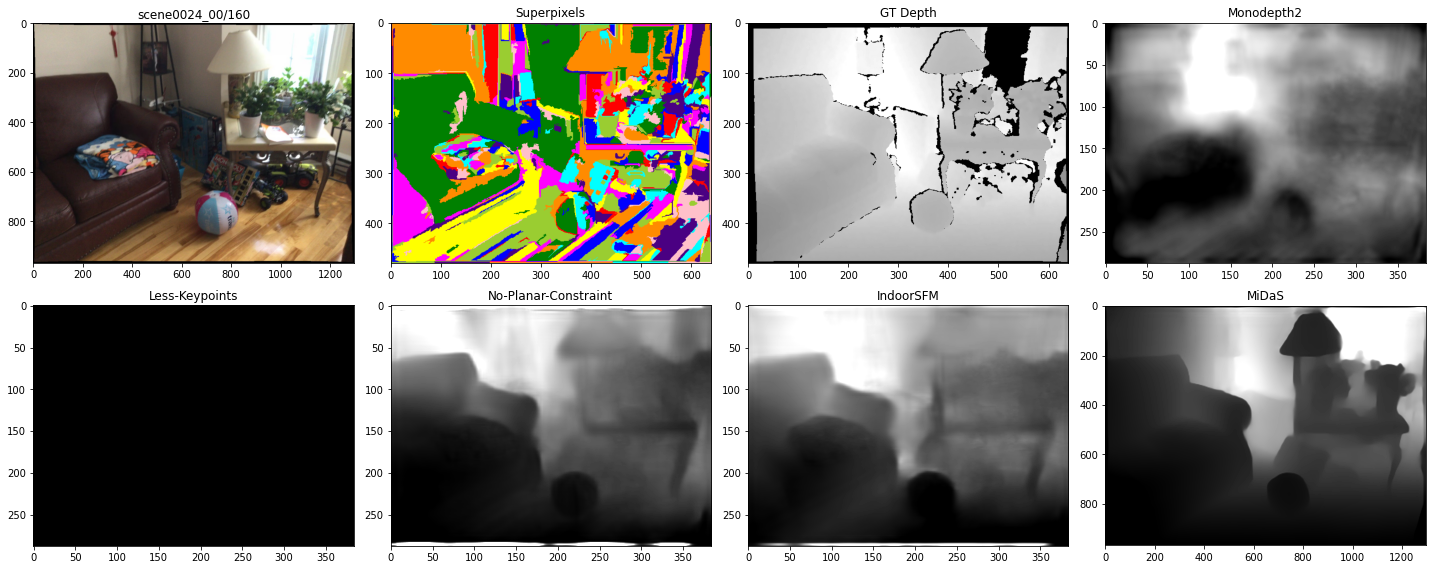

In [202]:
tgt_filepath = filenames[10]

data_dir = '/scratch/shantanu/scannet_data'

rgb = Image.open(os.path.join(data_dir, 'imgs', tgt_filepath.replace('.npy', '.png')))
gt_depth = np.load(os.path.join(data_dir, 'depths', tgt_filepath))
min_depth, max_depth = np.percentile(gt_depth, [5, 95])
gt_depth = np.clip((gt_depth - min_depth) / (max_depth - min_depth + 1e-6), 0, 1)

seg = np.load(os.path.join(data_dir, 'superpixels', os.path.dirname(tgt_filepath),
                           'seg_' + os.path.basename(tgt_filepath).replace('.npy', '.npz')))['segment_0']

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 8))
ax = ax.flatten()

ax[0].imshow(rgb)
ax[0].set_title(os.path.splitext(tgt_filepath)[0])

ax[1].imshow(label2rgb(seg))
ax[1].set_title('Superpixels')

ax[2].imshow(gt_depth, 'gray')
ax[2].set_title('GT Depth')

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# ax = ax.flatten()

for idx, (model_name, model_path) in enumerate(model_dict.items()):
    pred_disp = np.load(os.path.join(model_path, 'predictions', tgt_filepath))
    pred_depth = 1 / pred_disp
#     pred_depth = (pred_depth - pred_depth.min()) / (pred_depth.max() - pred_depth.min() + 1e-6)
    min_depth, max_depth = np.percentile(pred_depth, [5, 95])
    pred_depth = np.clip((pred_depth - min_depth) / (max_depth - min_depth + 1e-6), 0, 1)
    ax[idx + 3].imshow(pred_depth, 'gray')
    ax[idx + 3].set_title(model_name)
    
plt.tight_layout()
plt.show()

In [194]:
def compute_errors(gt, pred):
    gt += 1e-6
    pred += 1e-6
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [195]:
median_scaling = True
MIN_DEPTH = 0.1
MAX_DEPTH = 10.0

data_dir = '/scratch/shantanu/scannet_data'


for model_name, model_path in model_dict.items():
    
    errors = []
    for filename in filenames:
        gt_depth = np.load(os.path.join(data_dir, 'depths', filename)).astype(np.float32) / 1000
        gt_height, gt_width = gt_depth.shape[:2]

        pred_disp = np.load(os.path.join(model_path, 'predictions', filename))
        pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
        pred_depth = 1 / pred_disp

        mask = gt_depth > 0

        pred_depth = pred_depth[mask]
        gt_depth = gt_depth[mask]

        if median_scaling:
            ratio = np.median(gt_depth) / np.median(pred_depth)
            pred_depth *= ratio

            pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
            pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
        else:
            min_depth, max_depth = np.percentile(gt_depth, [5, 95])
            gt_depth = np.clip((gt_depth - min_depth) / (max_depth - min_depth + 1e-6), 0, 1)

            min_depth, max_depth = np.percentile(pred_depth, [5, 95])
            pred_depth = np.clip((pred_depth - min_depth) / (max_depth - min_depth + 1e-6), 0, 1)

        errors.append(compute_errors(gt_depth, pred_depth))

    mean_errors = np.array(errors).mean(0)

    print('\n {}'.format(model_name))
    print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
    print(("|{: 8.3f}  " * 7).format(*mean_errors.tolist()))
    print("_" * 80)


 Monodepth2

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
|   0.203  |   0.178  |   0.588  |   0.252  |   0.693  |   0.902  |   0.966  
________________________________________________________________________________

 Less-Keypoints

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
|   0.260  |   0.268  |   0.732  |   0.315  |   0.603  |   0.831  |   0.928  
________________________________________________________________________________

 No-Planar-Constraint

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
|   0.189  |   0.263  |   0.678  |   0.239  |   0.753  |   0.935  |   0.979  
________________________________________________________________________________

 IndoorSFM

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
|   0.163  |   0.115  |   0.501  |   0.207  |   0.770  |   0.942  |   0.984  
________________________________________________________

/home/shantanusingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide



 MiDaS

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
|   0.229  |   0.425  |   1.022  |   0.269  |   0.700  |   0.893  |   0.958  
________________________________________________________________________________


In [177]:
# Code to fix eval split

# train_filepath = '/scratch/shantanu/Indoor-SfMLearner/splits/scannet_train_depth.txt'

# with open(train_filepath, 'r') as f:
#     train_filepaths = f.read().splitlines()
    
# train_folders = set()
# for row in train_filepaths:
#     elem1 = row.split(' ')[0]
#     folder = elem1.split('/')[1].split('_')[0]
#     train_folders.add(folder)
    

# filenames = []
# for scene in os.listdir('/scratch/shantanu/scannet_data/depths'):
#     if not scene.split('_')[0] in train_folders:
#         scene_files = os.listdir(os.path.join('/scratch/shantanu/scannet_data/depths', scene))
#         scene_files = sorted(scene_files, key=lambda x: int(os.path.splitext(x)[0]))[::4]
#         for filename in scene_files:
#             filenames.append('{} {}'.format(scene, filename.split('.')[0]))

            
# with open('/scratch/shantanu/project-eragon/monodepth2/splits/scannet/eval_files.txt', 'w') as f:
#     f.writelines([filename + '\n' for filename in filenames])